## Assignment 2 
#### -- Pattern Recognition
#### -- João Pedro Moreto Lourenção

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

#### Loading Datasets

In [281]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Verifying if exists missing values

In [282]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Converting Features from categorical into numerical and removing unnecessary features 

In [283]:
lbe_sex = LabelEncoder()

def preprocessing(data):
    if 'Age' in data.columns:
        data['Age'].fillna(data['Age'].median(), inplace=True)

    if 'Embarked' in data.columns:
        data.drop(['Embarked'], axis=1, inplace=True)
    
    if 'Fare' in data.columns:
        data['Fare'].fillna(data['Fare'].median(), inplace=True)

    if 'Cabin' in data.columns:
        data.drop(['Cabin'], axis=1, inplace=True)

    if 'Sex' in data.columns:
        data['Sex'] = lbe_sex.fit_transform(data['Sex'])

    return data

In [284]:
train = preprocessing(train)
test = preprocessing(test)

print(train.isnull().sum())
print(train.head())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
dtype: int64
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket     Fare  
0         A/5 21171   7.2500  
1          PC 17599  71.2833  
2  STON/O2. 3101282 

C:\Users\joaop\AppData\Local\Temp\ipykernel_30304\2285071413.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
C:\Users\joaop\AppData\Local\Temp\ipykernel_30304\2285071413.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [285]:
train.groupby('Sex')['Survived'].mean()

Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64

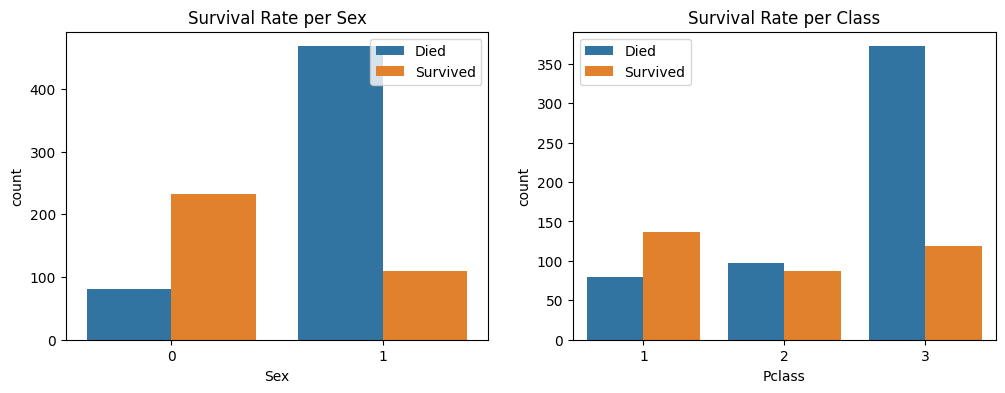

In [286]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x = 'Sex', hue='Survived', data=train)
plt. title('Survival Rate per Sex')
plt.legend(loc='upper right', labels=['Died', 'Survived'])

plt.subplot(1,2,2)
sns.countplot(x = 'Pclass', hue='Survived', data=train)
plt.title('Survival Rate per Class')
plt.legend(loc='upper left', labels=['Died', 'Survived'])

The mean of Age is: 29.36158249158249
The median of Age is: 28.0
The mode of Age is: 28.0


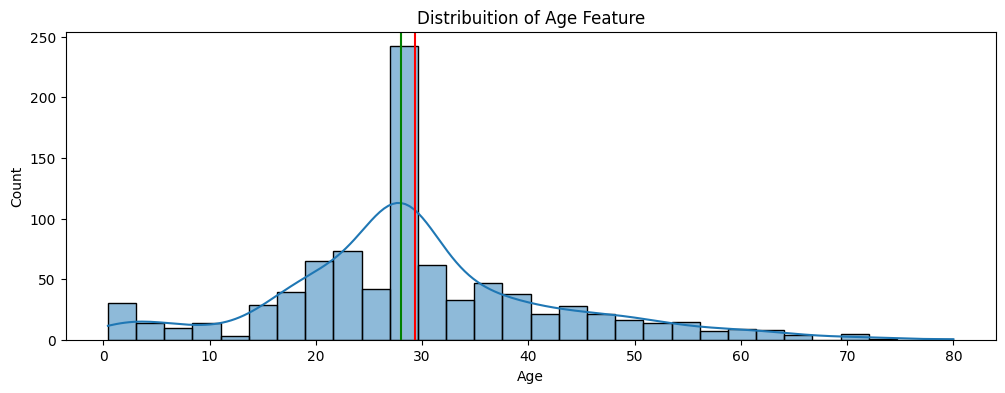

In [287]:
plt.figure(figsize=(12,4))

sns.histplot(train, x = 'Age', kde=True)
plt.title('Distribuition of Age Feature')
plt.axvline(train['Age'].mean(), color='red')
plt.axvline(train['Age'].median(), color='yellow')
plt.axvline(train['Age'].mode()[0], color='green')

print(f'The mean of Age is: {train['Age'].mean()}')
print(f'The median of Age is: {train['Age'].median()}')
print(f'The mode of Age is: {train['Age'].mode()[0]}')

### First classification model: Perceptron

In [288]:
y = train['Survived']

features = ['Pclass', 'Sex', 'SibSp', 'Parch']
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])


In [289]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X, y)

Perceptron(eta0=0.1, random_state=1)

In [290]:
y_val_pred_ppn = ppn.predict(X_test)

In [291]:
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_val_pred_ppn})
output.to_csv('out.csv', index=False)

#### SubSp + Parch = Alone, to verify if the person is alone and how it affects the prediction

In [292]:
train_copy = train.copy()
test_copy = test.copy()
train_copy['Alone']=np.where((train_copy["SibSp"]+train_copy["Parch"])>0, 0, 1)
train_copy.drop(['SibSp','Parch'],axis=1,inplace=True)
test_copy['Alone']=np.where((test_copy["SibSp"]+test_copy["Parch"])>0, 0, 1)
test_copy.drop(['SibSp','Parch'],axis=1,inplace=True)

features2 = ['Pclass', 'Sex', 'Alone']
X_alone = pd.get_dummies(train_copy[features2])
X_alone_test = pd.get_dummies(test_copy[features2])

ppn.fit(X_alone, y)

y_val_pred_ppn2 = ppn.predict(X_alone_test)

output2 = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_val_pred_ppn2})
output2.to_csv('out2.csv', index=False)

#### Identifying titles and how it affects the prediction

In [293]:
import re

def get_title(name):
    if pd.isnull(name):
        return "Unknown"
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return "Unknown"

train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

# Calculate the survival rate for each title
title_survival_rates = train.groupby('Title')['Survived'].mean()

train['Title_Survival_Rate'] = train['Title'].map(title_survival_rates)
test['Title_Survival_Rate'] = test['Title'].map(title_survival_rates)

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title_Survival_Rate']
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

if 'Title_Survival_Rate' in X_test.columns:
    X_test['Title_Survival_Rate'].fillna(X_test['Title_Survival_Rate'].median(), inplace=True)

ppn.fit(X, y)

y_val_pred_ppn3 = ppn.predict(X_test)

output3 = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_val_pred_ppn3})
output3.to_csv('out3.csv', index=False)

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\joaop\AppData\Local\Temp\ipykernel_30304\2536400053.py:6: SyntaxWarning: invalid escape sequence '\.'
  title_search = re.search(' ([A-Za-z]+)\.', name)
C:\Users\joaop\AppData\Local\Temp\ipykernel_30304\2536400053.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['Title_Survival_Rate'].fillna(X_test['Title_Survival_Rate'].median(), inplace=True)


### Second prediction model: Logistic Regression

In [294]:
lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')

lr.fit(X, y)
y_val_pred_lr = lr.predict(X_test)

output4 = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_val_pred_lr})
output4.to_csv('out4.csv', index=False)

c:\Users\joaop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [295]:
lr.fit(X_alone, y)
y_val_pred_lr2 = lr.predict(X_alone_test)

output5 = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_val_pred_lr2})
output5.to_csv('out5.csv', index=False)

c:\Users\joaop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [296]:
train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

# Calculate the survival rate for each title
title_survival_rates = train.groupby('Title')['Survived'].mean()

train['Title_Survival_Rate'] = train['Title'].map(title_survival_rates)
test['Title_Survival_Rate'] = test['Title'].map(title_survival_rates)

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title_Survival_Rate']
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

if 'Title_Survival_Rate' in X_test.columns:
    X_test['Title_Survival_Rate'].fillna(X_test['Title_Survival_Rate'].median(), inplace=True)

# Align train and test columns
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

lr.fit(X, y)

y_val_pred_lr3 = lr.predict(X_test)

output6 = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_val_pred_lr3})
output6.to_csv('out6.csv', index=False)

C:\Users\joaop\AppData\Local\Temp\ipykernel_30304\419014883.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['Title_Survival_Rate'].fillna(X_test['Title_Survival_Rate'].median(), inplace=True)
c:\Users\joaop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


### Third classification model: Support Vector Machine

In [297]:
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X, y)

y_val_pred_svm = svm.predict(X_test)

output7 = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_val_pred_svm})
output7.to_csv('out7.csv', index=False)

In [298]:
svm.fit(X_alone, y)
y_val_pred_svm2 = svm.predict(X_alone_test)

output8 = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_val_pred_svm2})
output8.to_csv('out8.csv', index=False)

In [299]:
train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

# Calculate the survival rate for each title
title_survival_rates = train.groupby('Title')['Survived'].mean()

train['Title_Survival_Rate'] = train['Title'].map(title_survival_rates)
test['Title_Survival_Rate'] = test['Title'].map(title_survival_rates)

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title_Survival_Rate']
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

if 'Title_Survival_Rate' in X_test.columns:
    X_test['Title_Survival_Rate'].fillna(X_test['Title_Survival_Rate'].median(), inplace=True)

# Align train and test columns
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)


svm.fit(X, y)

y_val_pred_svm3 = svm.predict(X_test)

output9 = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_val_pred_svm3})
output9.to_csv('out9.csv', index=False)

C:\Users\joaop\AppData\Local\Temp\ipykernel_30304\476101522.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['Title_Survival_Rate'].fillna(X_test['Title_Survival_Rate'].median(), inplace=True)


Text(0.5, 1.0, 'Kaggle Accuracy Scores')

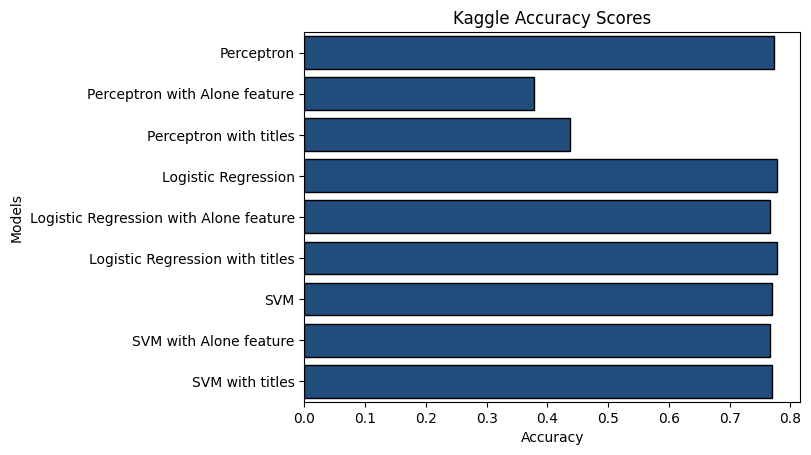

In [300]:
model_scores = [0.77272, 0.37799, 0.43779, 0.77751, 0.76555, 0.77751, 0.77033, 0.76555, 0.77033]

metrics = pd.DataFrame({'Accuracy': model_scores, 
                        'Models': ['Perceptron', 'Perceptron with Alone feature', 'Perceptron with titles', 'Logistic Regression', 'Logistic Regression with Alone feature', 'Logistic Regression with titles', 'SVM', 'SVM with Alone feature', 'SVM with titles']})
sns.barplot(data=metrics, y='Models', x='Accuracy', color='#114d8a', edgecolor='black')
plt.xticks(rotation=0)
plt.title('Kaggle Accuracy Scores')

C:\Users\joaop\AppData\Local\Temp\ipykernel_30304\469365713.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
C:\Users\joaop\AppData\Local\Temp\ipykernel_30304\469365713.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                    0
Ticket                 0
Fare                   0
Title                  0
Title_Survival_Rate    0
Alone                  0
dtype: int64
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  \
0                            Braund, Mr. Owen Harris    1  22.0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0   
2                             Heikkinen, Miss. Laina    0  26.0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0   
4                           Allen, Mr. William Henry    1  35.0   

             Ticket     Fare Title  Title_Survival_Rate  Alone  
0         A/5 21171   7.250

<Figure size 1000x600 with 0 Axes>

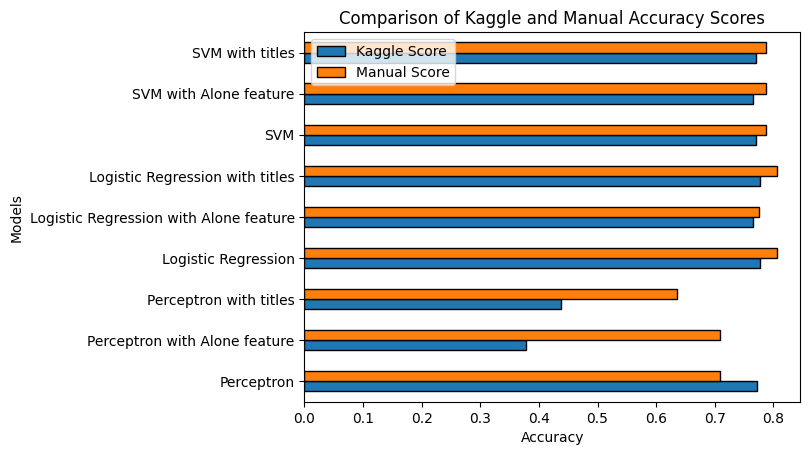

In [301]:
# Função de preprocessamento atualizada
def preprocessing(data):
    if 'Age' in data.columns:
        data['Age'].fillna(data['Age'].median(), inplace=True)

    if 'Embarked' in data.columns:
        data.drop(['Embarked'], axis=1, inplace=True)
    
    if 'Fare' in data.columns:
        data['Fare'].fillna(data['Fare'].median(), inplace=True)

    if 'Cabin' in data.columns:
        data.drop(['Cabin'], axis=1, inplace=True)

    if 'Sex' in data.columns:
        data['Sex'] = lbe_sex.fit_transform(data['Sex'])
    
    data['Alone'] = np.where((data["SibSp"] + data["Parch"]) > 0, 0, 1)
    data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

    return data

# Aplicando o preprocessamento
train = preprocessing(train)
test = preprocessing(test)

print(train.isnull().sum())
print(train.head())

y = train['Survived']

# Definindo modelos e features
models_features = [
    (ppn, ['Pclass', 'Sex', 'Alone']),
    (ppn, ['Pclass', 'Sex', 'Alone']),
    (ppn, ['Pclass', 'Sex', 'Alone', 'Title_Survival_Rate']),
    (lr, ['Pclass', 'Sex', 'Alone', 'Title_Survival_Rate']),
    (lr, ['Pclass', 'Sex', 'Alone']),
    (lr, ['Pclass', 'Sex', 'Alone', 'Title_Survival_Rate']),
    (svm, ['Pclass', 'Sex', 'Alone', 'Title_Survival_Rate']),
    (svm, ['Pclass', 'Sex', 'Alone']),
    (svm, ['Pclass', 'Sex', 'Alone', 'Title_Survival_Rate']),
]

# Calculando a acurácia para cada modelo
def calculate_accuracy(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    return scores.mean()

manual_scores = []
for model, features in models_features:
    X = pd.get_dummies(train[features])
    score = calculate_accuracy(model, X, y)
    manual_scores.append(score)

print(manual_scores)

# Pontuações do Kaggle
kaggle_scores = [0.77272, 0.37799, 0.43779, 0.77751, 0.76555, 0.77751, 0.77033, 0.76555, 0.77033]

# Comparação de scores
comparison_df = pd.DataFrame({
    'Model': ['Perceptron', 'Perceptron with Alone feature', 'Perceptron with titles', 
              'Logistic Regression', 'Logistic Regression with Alone feature', 
              'Logistic Regression with titles', 'SVM', 'SVM with Alone feature', 
              'SVM with titles'],
    'Kaggle Score': kaggle_scores,
    'Manual Score': manual_scores
})

comparison_df['Difference'] = comparison_df['Kaggle Score'] - comparison_df['Manual Score']

print(comparison_df)

# Visualização
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='barh', x='Model', y=['Kaggle Score', 'Manual Score'], edgecolor='black')
plt.title('Comparison of Kaggle and Manual Accuracy Scores')
plt.legend(loc='upper left')
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.xticks(rotation=0)
plt.show()
